In [1]:
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef

from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

sys.path.append("../../")

from helpers.split import tag_label_feature_split
from helpers.assess import make_confusion_matrix

DATASET_FOLDER = "../../datasets/"

In [2]:
# read a data set
df = pd.read_pickle(DATASET_FOLDER + "dataset_00_all_no_pop.pickle")

In [3]:
# get labels, a label encoder and features
_, (y, le), X = tag_label_feature_split(df, label_format="encoded")

In [4]:
# undersample to create balanced dataset
rus = RandomUnderSampler(random_state=1962)
X_res, y_res = rus.fit_resample(X, y)

In [5]:
# confirm the number of samples of each class
np.unique(y_res, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([361, 361, 361, 361, 361, 361, 361, 361, 361]))

In [6]:
# split into train/validation and test datasets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_res, y_res, test_size=0.2, shuffle=True, stratify=y_res, random_state=1962
)

In [7]:
# split training/validation into training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, shuffle=True, stratify=y_train_val, random_state=1962
)

In [8]:
# standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [9]:
classifier = XGBClassifier(
    learning_rate=.221461,
    n_estimators=827,
    max_depth=4,
    gamma=.524969,
    reg_alpha=4.327827,
    use_label_encoder=False,
    tree_method="gpu_hist",
    sampling_method="gradient_based",
    objective="multi:softprob",
    eval_metric=["mlogloss", "auc"], 
    early_stopping_rounds=5,
    seed=1962,
)

eval_set = [(X_train_scaled, y_train), (X_val_scaled, y_val)]
classifier.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric=['mlogloss', 'auc'], gamma=0.524969, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.221461, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=827, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=1962,
              reg_alpha=4.327827, ...)

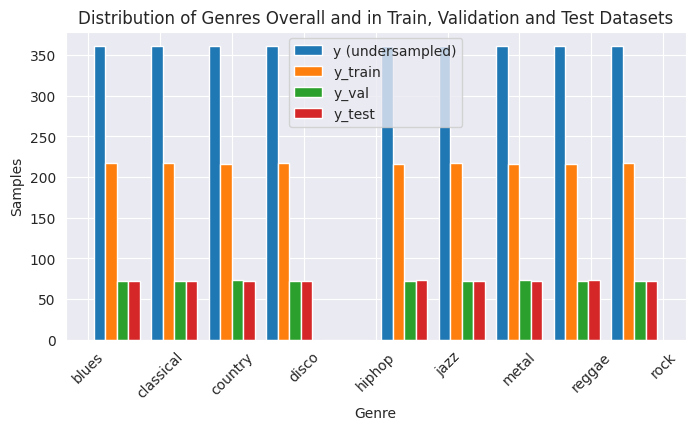

In [10]:
class_count = len(le.classes_)
x_labels = [label[6:] for label in le.inverse_transform(range(class_count))]
plt.figure(figsize=(8,4))
plt.hist([y_res, y_train, y_val, y_test], label=['y (undersampled)', 'y_train', 'y_val', 'y_test'])
plt.xticks(range(class_count), x_labels, rotation=45)
plt.title("Distribution of Genres Overall and in Train, Validation and Test Datasets")
plt.xlabel("Genre")
plt.ylabel("Samples")
plt.legend()
plt.show()

In [11]:
classifier_results = classifier.evals_result()

In [12]:
train_results=classifier_results['validation_0']
validation_results=classifier_results['validation_1']
test_predictions=classifier.predict(X_test_scaled)

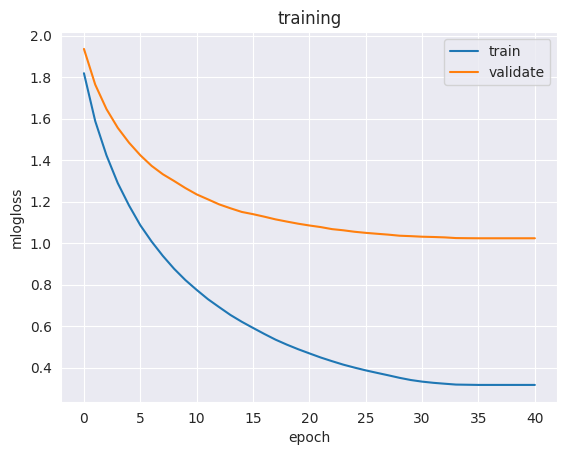

In [13]:
plt.plot(train_results['mlogloss'], label='train')
plt.plot(validation_results['mlogloss'], label='validate')
plt.title('training')
plt.xlabel('epoch')
plt.ylabel('mlogloss')
plt.legend()
plt.show()

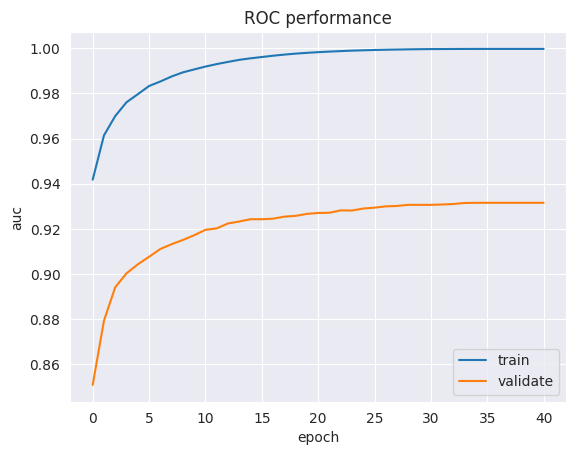

In [14]:
plt.plot(train_results['auc'], label='train')
plt.plot(validation_results['auc'], label='validate')
plt.title('ROC performance')
plt.xlabel('epoch')
plt.ylabel('auc')
plt.legend()
plt.show()

In [15]:
accuracy_score(y_test, test_predictions)

0.6384615384615384

In [16]:
matthews_corrcoef(y_test, test_predictions)

0.5936372037944696

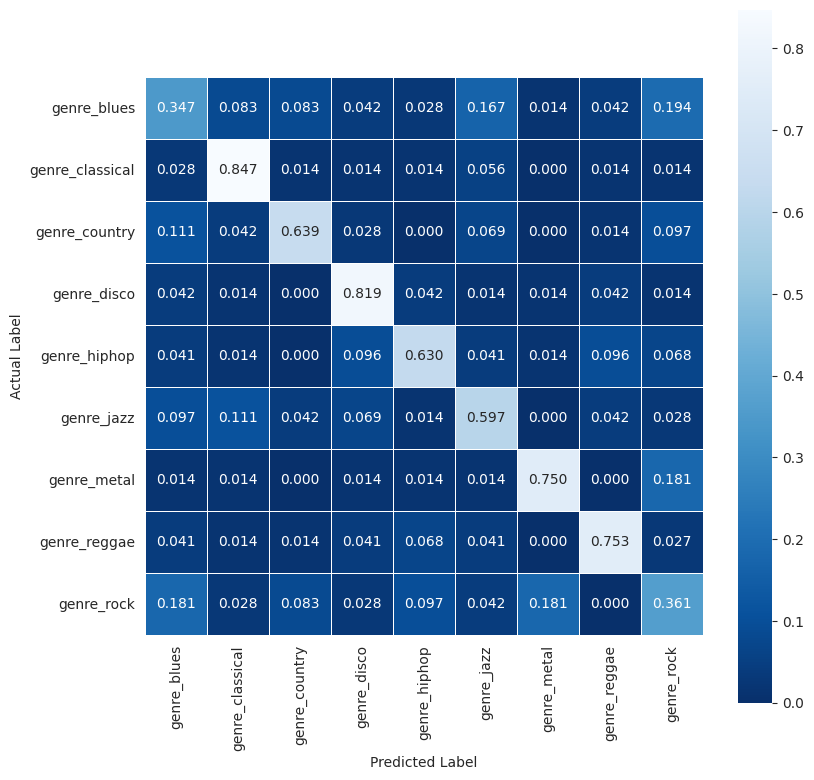

In [17]:
make_confusion_matrix(y_test, test_predictions, label_encoder=le)
pass